<a href="https://colab.research.google.com/github/harrywinks/installer/blob/main/byol_stl10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BYOL Demo

An end-to-end demonstration of BYOL in action, using STL10 as a toy dataset.

### Install dependencies

PyTorch and Torchvision are pre-installed in Colab instances, so no need to worry about those.

In [3]:
# Install dependencies.  Note that pytorch and torchvision are pre-installed 
# in standard Colab instances, so no need to worry about those.
!pip install -q kornia pytorch_lightning

### Data Augmentations

In [4]:
import random
from typing import Callable, Tuple

from kornia import augmentation as aug
from kornia import filters
from kornia.geometry import transform as tf
import torch
from torch import nn, Tensor


class RandomApply(nn.Module):
    def __init__(self, fn: Callable, p: float):
        super().__init__()
        self.fn = fn
        self.p = p

    def forward(self, x: Tensor) -> Tensor:
        return x if random.random() > self.p else self.fn(x)


def default_augmentation(image_size: Tuple[int, int] = (224, 224)) -> nn.Module:
    return nn.Sequential(
        tf.Resize(size=image_size),
        RandomApply(aug.ColorJitter(0.8, 0.8, 0.8, 0.2), p=0.8),
        aug.RandomGrayscale(p=0.2),
        aug.RandomHorizontalFlip(),
        RandomApply(filters.GaussianBlur2d((3, 3), (1.5, 1.5)), p=0.1),
        aug.RandomResizedCrop(size=image_size),
        aug.Normalize(
            mean=torch.tensor([0.485, 0.456, 0.406]),
            std=torch.tensor([0.229, 0.224, 0.225]),
        ),
    )

### Encoder Wrapper

Enables us to work with *any* model, not just ResNet18 which I chose for this demo.

In [5]:
from typing import Union


def mlp(dim: int, projection_size: int = 256, hidden_size: int = 4096) -> nn.Module:
    return nn.Sequential(
        nn.Linear(dim, hidden_size),
        nn.BatchNorm1d(hidden_size),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_size, projection_size),
    )


class EncoderWrapper(nn.Module):
    def __init__(
        self,
        model: nn.Module,
        projection_size: int = 256,
        hidden_size: int = 4096,
        layer: Union[str, int] = -2,
    ):
        super().__init__()
        self.model = model
        self.projection_size = projection_size
        self.hidden_size = hidden_size
        self.layer = layer

        self._projector = None
        self._projector_dim = None
        self._encoded = torch.empty(0)
        self._register_hook()

    @property
    def projector(self):
        if self._projector is None:
            self._projector = mlp(
                self._projector_dim, self.projection_size, self.hidden_size
            )
        return self._projector

    def _hook(self, _, __, output):
        output = output.flatten(start_dim=1)
        if self._projector_dim is None:
            self._projector_dim = output.shape[-1]
        self._encoded = self.projector(output)

    def _register_hook(self):
        if isinstance(self.layer, str):
            layer = dict([*self.model.named_modules()])[self.layer]
        else:
            layer = list(self.model.children())[self.layer]

        layer.register_forward_hook(self._hook)

    def forward(self, x: Tensor) -> Tensor:
        _ = self.model(x)
        return self._encoded

### BYOL and Training Code

Encapsulate BYOL into a single module.  I use PyTorch Lightning here, because it makes training very easy.  This code also works for multi-GPU or TPU training, and experiments are logged automatically.

In [18]:
from copy import deepcopy
from itertools import chain
from typing import Dict, List

import pytorch_lightning as pl
from torch import optim
import torch.nn.functional as f


def normalized_mse(x: Tensor, y: Tensor) -> Tensor:
    x = f.normalize(x, dim=-1)
    y = f.normalize(y, dim=-1)
    return 2 - 2 * (x * y).sum(dim=-1)


class BYOL(pl.LightningModule):
    def __init__(
        self,
        model: nn.Module,
        image_size: Tuple[int, int] = (96, 96),
        hidden_layer: Union[str, int] = -2,
        projection_size: int = 256,
        hidden_size: int = 4096,
        augment_fn: Callable = None,
        beta: float = 0.999,
        **hparams,
    ):
        super().__init__()
        self.augment = default_augmentation(image_size) if augment_fn is None else augment_fn
        self.beta = beta
        self.encoder = EncoderWrapper(
            model, projection_size, hidden_size, layer=hidden_layer
        )
        self.predictor = nn.Linear(projection_size, projection_size, hidden_size)
        for key in hparams.keys():
            self.hparams[key]=hparams[key]
        self._target = None

        self.encoder(torch.zeros(2, 3, *image_size))

    def forward(self, x: Tensor) -> Tensor:
        return self.predictor(self.encoder(x))

    @property
    def target(self):
        if self._target is None:
            self._target = deepcopy(self.encoder)
        return self._target

    def update_target(self):
        for p, pt in zip(self.encoder.parameters(), self.target.parameters()):
            pt.data = self.beta * pt.data + (1 - self.beta) * p.data

    # --- Methods required for PyTorch Lightning only! ---

    def configure_optimizers(self):
        optimizer = getattr(optim, self.hparams.get("optimizer", "Adam"))
        lr = self.hparams.get("lr", 1e-4)
        weight_decay = self.hparams.get("weight_decay", 1e-6)
        return optimizer(self.parameters(), lr=lr, weight_decay=weight_decay)

    def training_step(self, batch, *_) -> Dict[str, Union[Tensor, Dict]]:
        x = batch[0]
        with torch.no_grad():
            x1, x2 = self.augment(x), self.augment(x)

        pred1, pred2 = self.forward(x1), self.forward(x2)
        with torch.no_grad():
            targ1, targ2 = self.target(x1), self.target(x2)
        loss = torch.mean(normalized_mse(pred1, targ2) + normalized_mse(pred2, targ1))

        self.log("train_loss", loss.item())
        self.update_target()

        return {"loss": loss}

    @torch.no_grad()
    def validation_step(self, batch, *_) -> Dict[str, Union[Tensor, Dict]]:
        x = batch[0]
        x1, x2 = self.augment(x), self.augment(x)
        pred1, pred2 = self.forward(x1), self.forward(x2)
        targ1, targ2 = self.target(x1), self.target(x2)
        loss = torch.mean(normalized_mse(pred1, targ2) + normalized_mse(pred2, targ1))

        return {"loss": loss}

    @torch.no_grad()
    def validation_epoch_end(self, outputs: List[Dict]) -> Dict:
        val_loss = sum(x["loss"] for x in outputs) / len(outputs)
        self.log("val_loss", val_loss.item())

### Supervised Training Module

We also need a Lightning module for supervised training on STL10, after any self-supervised training has completed.  There's not much special here -- just standard supervised training.

In [7]:
class SupervisedLightningModule(pl.LightningModule):
    def __init__(self, model: nn.Module, **hparams):
        super().__init__()
        self.model = model

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)

    def configure_optimizers(self):
        optimizer = getattr(optim, self.hparams.get("optimizer", "Adam"))
        lr = self.hparams.get("lr", 1e-4)
        weight_decay = self.hparams.get("weight_decay", 1e-6)
        return optimizer(self.parameters(), lr=lr, weight_decay=weight_decay)

    def training_step(self, batch, *_) -> Dict[str, Union[Tensor, Dict]]:
        x, y = batch
        loss = f.cross_entropy(self.forward(x), y)
        self.log("train_loss", loss.item())
        return {"loss": loss}

    @torch.no_grad()
    def validation_step(self, batch, *_) -> Dict[str, Union[Tensor, Dict]]:
        x, y = batch
        loss = f.cross_entropy(self.forward(x), y)
        return {"loss": loss}

    @torch.no_grad()
    def validation_epoch_end(self, outputs: List[Dict]) -> Dict:
        val_loss = sum(x["loss"] for x in outputs) / len(outputs)
        self.log("val_loss", val_loss.item())

### STL10 Datasets

We need 3 separate datasets from STL10 for this experiment:
1. `"train"` -- Contains only labeled training images. Used for supervised training.
2. `"train+unlabeled"` -- Contains training images, plus a large number of unlabelled images.  Used for self-supervised learning with BYOL.
3. `"test"` -- Labeled test images.  We use it both as a validation set, and for computing the final model accuracy.

In [8]:
from torchvision.datasets import STL10
from torchvision.transforms import ToTensor


TRAIN_DATASET = STL10(root="data", split="train", download=True, transform=ToTensor())
TRAIN_UNLABELED_DATASET = STL10(
    root="data", split="train+unlabeled", download=True, transform=ToTensor()
)
TEST_DATASET = STL10(root="data", split="test", download=True, transform=ToTensor())

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting data/stl10_binary.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


### Supervised Training without BYOL

Run through supervised training, and measure the accuracy.  Performance should be pretty good already. 

In [9]:
from os import cpu_count

from torch.utils.data import DataLoader
from torchvision.models import resnet50


model = resnet50(pretrained=True)
supervised = SupervisedLightningModule(model)
trainer = pl.Trainer(max_epochs=25, gpus=-1, weights_summary=None)
train_loader = DataLoader(
    TRAIN_DATASET,
    batch_size=128,
    shuffle=True,
    drop_last=True,
)
val_loader = DataLoader(
    TEST_DATASET,
    batch_size=128,
)
trainer.fit(supervised, train_loader, val_loader)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers whic

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [10]:
def accuracy(pred: Tensor, labels: Tensor) -> float:
    return (pred.argmax(dim=-1) == labels).float().mean().item()


model.cuda()
acc = sum([accuracy(model(x.cuda()), y.cuda()) for x, y in val_loader]) / len(val_loader)
print(f"Accuracy: {acc:.3f}")

Accuracy: 0.886


In [12]:
- [SSL] veri-wild에서는 BYOL encoder(=resnet50)을 가져와서 pretrained weight으로 사용
- [Linear evaluation] stl-10에서는 BYOL encoder(=resnet50)에 fc layer달아서 실험

SyntaxError: ignored

## 10.08 실행주


### Self-Supervised Training with BYOL

Perform our self-supervised training.  This is the most computationally intensive part of the script.  It takes roughly 45 minutes on a standard Colab instance with a K80 GPU.

In [19]:
from torchvision.models import resnet50
model2 = resnet50(pretrained=True)
byol = BYOL(model2, image_size=(96, 96))
trainer = pl.Trainer(
    max_epochs=50, 
    gpus=-1,
    accumulate_grad_batches=2048 // 128,
    weights_summary=None,
)
train_loader_b = DataLoader(
    TRAIN_DATASET,
    batch_size=128,
    shuffle=True,
    drop_last=True,
)
val_loader_b = DataLoader(
    TEST_DATASET,
    batch_size=128,
)
trainer.fit(byol, train_loader_b, val_loader_b)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:327: UserWarning: The number of training samples (39) i

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Supervised Training Again

Extract the state dictionary from BYOL, and load it into our ResNet18 model before starting training.  Then run supervised training, and watch the accuracy improve from last time!

In [21]:
# Extract the state dictionary, initialize a new ResNet18 model,
# and load the state dictionary into the new model.
#
# This ensures that we remove all hooks from the previous model,
# which are automatically implemented by BYOL. model을 model2로 수정
state_dict = model2.state_dict()
model = resnet50()
model.load_state_dict(state_dict)

supervised = SupervisedLightningModule(model)
trainer = pl.Trainer(
    max_epochs=25, 
    gpus=-1,
    weights_summary=None,
)
train_loader = DataLoader(
    TRAIN_DATASET,
    batch_size=128,
    shuffle=True,
    drop_last=True,
)
trainer.fit(supervised, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:327: UserWarning: The number of training samples (39) i

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [22]:
def accuracy(pred: Tensor, labels: Tensor) -> float:
    return (pred.argmax(dim=-1) == labels).float().mean().item()


model.cuda()
acc = sum([accuracy(model(x.cuda()), y.cuda()) for x, y in val_loader]) / len(val_loader)
print(f"Accuracy: {acc:.3f}")

Accuracy: 0.879


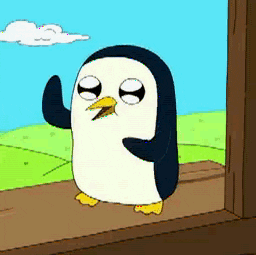